In [1]:
import GPy as gpy
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

 /Users/ipaulo/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


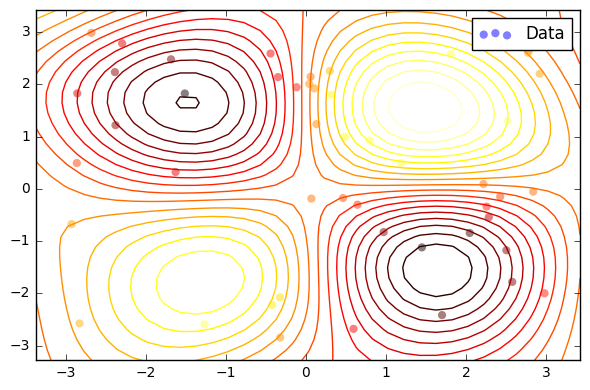

In [68]:
X = np.random.uniform(-3.,3.,(50,2))
f = lambda x:  np.sin(x[:,0:1]) * np.sin(x[:,1:2])+np.random.randn(50,1)*0.05
Y = f(X)
X_test = np.random.uniform(-3.,3.,(50,2))
Y_test = f(X_test)


# define kernel
ker = gpy.kern.RBF(2, ARD=True) + gpy.kern.White(2)


# create simple GP model
m = gpy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(max_f_eval = 1000)
fig = m.plot()
# display(gpy.plotting.show(fig)) #, filename='basic_gp_regression_notebook_2d'))
# display(m)
# m.predict(X_test)

In [91]:
means_true, vars_true = m.predict_noiseless(X_test)
# mr, vr = m._raw_predict(X_test, full_cov=False, kern=None) 
# np.allclose(mr, means_true), np.allclose(vr, vars_true), np.allclose(m._predictive_variable, X)
# mu, var = m.posterior._raw_predict(kern=m.kern, Xnew=X_test, pred_var=m._predictive_variable, full_cov=False)

from GPy.util.linalg import dtrtrs
Kx = m.kern.K(X, X_test)
m_test = np.dot(Kx.T, m.posterior.woodbury_vector)
Kxx = m.kern.Kdiag(X_test)
# if self._woodbury_chol.ndim == 2:  – this is strange
tmp = dtrtrs(m.posterior._woodbury_chol, Kx)[0]
var_test = (Kxx - np.square(tmp).sum(0))[:, None]

In [92]:
np.allclose(m_test, means_true), np.allclose(var_test, vars_true)

(True, True)

In [ ]:
woodbury_chol : a lower triangular matrix L that satisfies posterior_covariance = K - K L^{-T} L^{-1} K
woodbury_vector : a matrix (or vector, as Nx1 matrix) M which satisfies posterior_mean = K M
K : the proir covariance (required for lazy computation of various quantities)
mean : the posterior mean
cov : the posterior covariance

In [93]:
m.posterior?

Type:            PosteriorExact
String form:     <GPy.inference.latent_function_inference.posterior.PosteriorExact object at 0x10e31b2b0>
File:            ~/anaconda/lib/python3.5/site-packages/GPy/inference/latent_function_inference/posterior.py
Docstring:       <no docstring>
Class docstring:
An object to represent a Gaussian posterior over latent function values, p(f|D).
This may be computed exactly for Gaussian likelihoods, or approximated for
non-Gaussian likelihoods.

The purpose of this class is to serve as an interface between the inference
schemes and the model classes.  the model class can make predictions for
the function at any new point x_* by integrating over this posterior.
Init docstring:
 woodbury_chol : a lower triangular matrix L that satisfies posterior_covariance = K - K L^{-T} L^{-1} K
 woodbury_vector : a matrix (or vector, as Nx1 matrix) M which satisfies posterior_mean = K M
 K : the proir covariance (required for lazy computation of various quantities)
 mean :

In [46]:
m.posterior??

Type:            PosteriorExact
String form:     <GPy.inference.latent_function_inference.posterior.PosteriorExact object at 0x10e25aa20>
File:            ~/anaconda/lib/python3.5/site-packages/GPy/inference/latent_function_inference/posterior.py
Source:
class PosteriorExact(Posterior):
     
    def _raw_predict(self, kern, Xnew, pred_var, full_cov=False):
        
        Kx = kern.K(pred_var, Xnew)
        mu = np.dot(Kx.T, self.woodbury_vector)
        if len(mu.shape)==1:
            mu = mu.reshape(-1,1)
        if full_cov:
            Kxx = kern.K(Xnew)
            if self._woodbury_chol.ndim == 2:
                tmp = dtrtrs(self._woodbury_chol, Kx)[0]
                var = Kxx - tdot(tmp.T)
            elif self._woodbury_chol.ndim == 3: # Missing data
                var = np.empty((Kxx.shape[0],Kxx.shape[1],self._woodbury_chol.shape[2]))
                for i in range(var.shape[2]):
                    tmp = dtrtrs(self._woodbury_chol[:,:,i], Kx)[0]
                    var

In [12]:
m._raw_predict??

Signature: m._raw_predict(Xnew, full_cov=False, kern=None)
Source:
    def _raw_predict(self, Xnew, full_cov=False, kern=None):
        """
        For making predictions, does not account for normalization or likelihood

        full_cov is a boolean which defines whether the full covariance matrix
        of the prediction is computed. If full_cov is False (default), only the
        diagonal of the covariance is returned.

        .. math::
            p(f*|X*, X, Y) = \int^{\inf}_{\inf} p(f*|f,X*)p(f|X,Y) df
                        = N(f*| K_{x*x}(K_{xx} + \Sigma)^{-1}Y, K_{x*x*} - K_{xx*}(K_{xx} + \Sigma)^{-1}K_{xx*}
            \Sigma := \texttt{Likelihood.variance / Approximate likelihood covariance}
        """
        mu, var = self.posterior._raw_predict(kern=self.kern if kern is None else kern, Xnew=Xnew, pred_var=self._predictive_variable, full_cov=full_cov)
        if self.mean_function is not None:
            mu += self.mean_function.f(Xnew)
        return mu, var
File: 

In [11]:
m.likelihood.predictive_values??

Signature: m.likelihood.predictive_values(mu, var, full_cov=False, Y_metadata=None)
Source:
    def predictive_values(self, mu, var, full_cov=False, Y_metadata=None):
        if full_cov:
            if var.ndim == 2:
                var += np.eye(var.shape[0])*self.variance
            if var.ndim == 3:
                var += np.atleast_3d(np.eye(var.shape[0])*self.variance)
        else:
            var += self.variance
        return mu, var
File:      ~/anaconda/lib/python3.5/site-packages/GPy/likelihoods/gaussian.py
Type:      method